In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF
from numpy import asarray
from numpy import savetxt
import matplotlib.colors as mcolors
import matplotlib.cm
import matplotlib.patches as mpatches
import umap

import scanpy as sc

### Read in data

Select either the whole sc transformed dataset or just the variable genes

In [2]:
ILC_var = sc.read("sct_variable.h5ad")
#ILC = sc.read("sct.h5ad")

c:\users\hmkri\desktop\riesenfeld pearson\lib\site-packages\anndata\compat\__init__.py:158: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
c:\users\hmkri\desktop\riesenfeld pearson\lib\site-packages\anndata\compat\__init__.py:158: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


Types of data stored in the object:

In [3]:
ILC_var

AnnData object with n_obs × n_vars = 26877 × 3000
    obs: 'ClusterID', 'ClusterName', 'nCount_RNA', 'nCount_SCT', 'nFeature_RNA', 'nFeature_SCT', 'orig_ident', 'pct_mt', 'percent_mt', 'timept', 'day', 'lda_1', 'lda_2', 'lda_3', 'lda_4', 'lda_5', 'lda_6', 'lda_7', 'lda_8', 'lda_9', 'lda_10', 'lda_11', 'lda_12', 'lda_13', 'lda_14', 'lda_15', 'lda_16', 'lda_17', 'ilc3_precursors_ot', 'ilc3_endpoints', 'quiescent_endpt_day0', 'quiescent_endpt_day4', 'ilc2_endpt_day0', 'ilc2_endpt_day4', 'cloud_entpt', 'dpt_pseudotime', 'quiescent_ilc3', 'cloud_ilc3', 'ilc2_quiescent', 'ilc2_ilc3'
    var: 'Selected', 'sct_detection_rate', 'sct_gmean', 'sct_residual_mean', 'sct_residual_variance', 'sct_variable', 'sct_variance'
    uns: 'diffmap_evals', 'draw_graph', 'iroot', 'neighbors', 'pca'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_pca', 'pca_cell_embeddings', 'umap_cell_embeddings'
    varm: 'PCs', 'pca_feature_loadings'
    layers: 'count_data', 'norm_data', 'scale_data'
    obsp: 'distances', 'co

In [4]:
norm_reads_sparse = ILC_var.layers["norm_data"]
day = ILC_var.obs["day"]
UMAP = ILC_var.obsm["umap_cell_embeddings"]
Diff = ILC_var.obsm['X_draw_graph_fa']

In [5]:
print("Norm reads: "+repr(type(norm_reads_sparse)))
print("Day information: "+repr(type(day)))
print("UMAP: "+repr(type(UMAP)))

Norm reads: <class 'scipy.sparse.csr.csr_matrix'>
Day information: <class 'pandas.core.series.Series'>
UMAP: <class 'numpy.ndarray'>


### Types of visualizations of the data stored in the h5ad file

For this data, individual genes are accessed for each cell in the following way

In [6]:
Yfp = ILC_var[:,"Yfp"].X
Yfp = pd.DataFrame(Yfp.toarray())

Fos = ILC_var[:,"Fos"].X
Fos = pd.DataFrame(Fos.toarray())

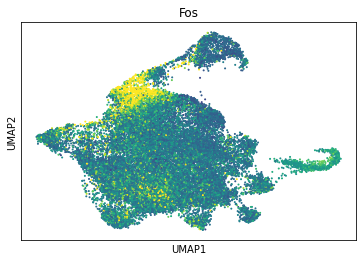

In [7]:
vmin = np.mean(Fos[0]) - 2* np.std(Fos[0])
vmax = np.mean(Fos[0]) + 2* np.std(Fos[0])

frame1 = plt.scatter(UMAP[:,0], UMAP[:,1], s= 1, c = Fos[0], vmin = vmin, vmax = vmax)
plt.title('Fos')
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.show()

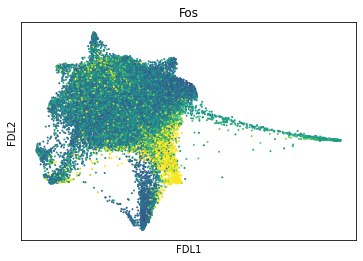

In [8]:
vmin = np.mean(Fos[0]) - 2* np.std(Fos[0])
vmax = np.mean(Fos[0]) + 2* np.std(Fos[0])

frame1 = plt.scatter(Diff[:,0], Diff[:,1], s= 1, c = Fos[0], vmin = vmin, vmax = vmax)
plt.title('Fos')
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('FDL2')
plt.xlabel('FDL1')
plt.show()

In [9]:
day = ILC_var.obs["day"]

df = pd.DataFrame(dict(day = day))
colors = {'0':'midnightblue', '1':'dodgerblue', '2':'springgreen', '3':'greenyellow', '4':'gold'}

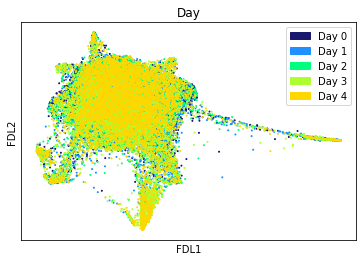

In [10]:
Day_0 = mpatches.Patch(color='midnightblue', label='Day 0')
Day_1 = mpatches.Patch(color='dodgerblue', label='Day 1')
Day_2 = mpatches.Patch(color='springgreen', label='Day 2')
Day_3 = mpatches.Patch(color='greenyellow', label='Day 3')
Day_4 = mpatches.Patch(color='gold', label='Day 4')

frame1 = plt.scatter(Diff[:,0], Diff[:,1], s= 1, c = day.map(colors))
plt.title('Day')
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('FDL2')
plt.xlabel('FDL1')
plt.legend(handles=[Day_0, Day_1, Day_2, Day_3, Day_4])
plt.show()

## Selecting all ILC2 and ILC3 cells

In this model of psoriasis, tissue resident ILC2s are reprogramed to ILC3s. 

For analysis we are selecting for cells likely to be ILC2s or ILC3s on the basis of previously characterized populations.

In [11]:
norm_reads = pd.DataFrame(norm_reads_sparse.toarray())
print("Norm reads: "+repr(norm_reads.shape))

Norm reads: (26877, 3000)


Selecting cells:

In [12]:
Variable = ILC_var.var
Obs = ILC_var.obs


#Variable["Selected"].to_csv('Gene_list_ILC.csv', sep=',')
O = Obs["ilc2_ilc3"].to_frame()
#O.to_csv('Cell_list_ILC.csv', sep=',')

In [13]:
Gene_list = pd.read_csv("Gene_list_ILC.csv", sep=",", header = None)
Cell_list = pd.read_csv("Cell_list_ILC.csv", sep=",", header = None)

<class 'pandas.core.series.Series'>


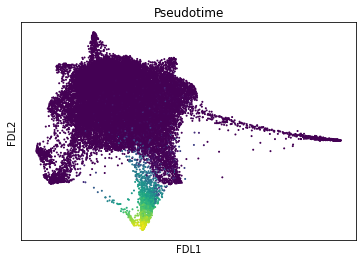

In [14]:
pseudotime = -1 * ILC_var.obs["dpt_pseudotime"]

print(type(pseudotime))

df = pd.DataFrame(dict(pseudotime = pseudotime))
vmin = np.mean(pseudotime)

frame1 = plt.scatter(Diff[:,0], Diff[:,1], s= 1, c = pseudotime, vmin = vmin)
plt.title('Pseudotime')
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('FDL2')
plt.xlabel('FDL1')
plt.show()

3807


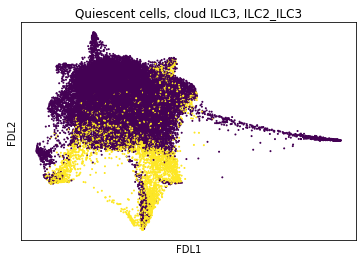

In [15]:
ILC2_ILC3 = ILC_var.obs["ilc2_ilc3"]
ILC3_Q = ILC_var.obs["quiescent_ilc3"]
ILC2_Q = ILC_var.obs["ilc2_quiescent"]
cloud_ILC3 = ILC_var.obs["cloud_ilc3"]

df = pd.DataFrame(dict(ILC2_ILC3 = ILC2_ILC3, ILC3_Q = ILC3_Q, ILC2_Q = ILC2_Q, cloud_ILC3 = cloud_ILC3))
cells = df.shape[0]

in_transition = np.zeros((cells, 1))
transition_val = np.zeros((cells, 1))
index_cells = np.zeros((cells, 1))
ILC_val = np.zeros((3807, 1))
index_val = np.array([])
index_cells = index_cells.astype(str)
number = 0

for i in range(0,cells):
    if np.isnan(df["ILC2_ILC3"][i]):

        if np.isnan(df["ILC3_Q"][i]):

            if np.isnan(df["ILC2_Q"][i]):

                if np.isnan(df["cloud_ILC3"][i]):

                    in_transition[i,0] = 0
                    transition_val[i,0] = 0
                    index_cells[i,0] = "0"
                    
                else:
                    in_transition[i,0] = 1
                    transition_val[i,0] = df["ILC2_ILC3"][i]
                    index_cells[i,0] = Cell_list[0][i]
                    ILC_val[number] = df["ILC2_ILC3"][i]
                    index_val = np.append(index_val , df["ILC2_ILC3"].index[i])
                    number += 1
            else:
                in_transition[i,0] = 1
                transition_val[i,0] = df["ILC2_ILC3"][i]
                index_cells[i,0] = Cell_list[0][i]
                ILC_val[number] = df["ILC2_ILC3"][i]
                index_val = np.append(index_val , df["ILC2_ILC3"].index[i])
                number += 1             

        else:
            in_transition[i,0] = 1
            transition_val[i,0] = df["ILC2_ILC3"][i]
            index_cells[i,0] = Cell_list[0][i]
            ILC_val[number] = df["ILC2_ILC3"][i]
            index_val = np.append(index_val , df["ILC2_ILC3"].index[i])
            number += 1
    
    else:
        in_transition[i,0] = 1
        transition_val[i,0] = df["ILC2_ILC3"][i]
        index_cells[i,0] = Cell_list[0][i]
        ILC_val[number] = df["ILC2_ILC3"][i]
        index_val = np.append(index_val , df["ILC2_ILC3"].index[i])
        number += 1

print(number)
    
frame2 = plt.scatter(Diff[:,0], Diff[:,1], s= 1, c = in_transition)
plt.title('Quiescent cells, cloud ILC3, ILC2_ILC3')
#plt.xlim(-30000,25000)
frame2.axes.get_xaxis().set_ticks([])
frame2.axes.get_yaxis().set_ticks([])
plt.ylabel('FDL2')
plt.xlabel('FDL1')
plt.show()



In [16]:
df

,ILC2_ILC3,ILC3_Q,ILC2_Q,cloud_ILC3
index,,,,
Timept0.AAACCCAAGCTATCTG,0.378434,NaN,0.383517,NaN
Timept0.AAACCCAAGGTAATCA,NaN,NaN,NaN,NaN
Timept0.AAACCCAAGTCTAACC,NaN,NaN,NaN,NaN
Timept0.AAACCCAAGTCTCTGA,NaN,NaN,NaN,NaN
Timept0.AAACCCACACACCTGG,NaN,NaN,NaN,NaN
...,...,...,...,...
Timept4.TTTGTTGCAAAGAGTT,0.063145,NaN,0.057468,NaN
Timept4.TTTGTTGCAGTCTTCC,0.866779,0.830105,NaN,0.814476
Timept4.TTTGTTGCATCCAATG,NaN,NaN,NaN,NaN


In [17]:
index_val.shape

(3807,)

In [18]:
Cell_list
Gene_list

,0
0,Yfp
1,Rb1cc1
2,Mcmdc2
3,Cspp1
4,Ncoa2
...,...
2995,mt-Nd4l
2996,mt-Nd4
2997,mt-Cytb
2998,AC149090.1


In [19]:
print(cells)
norm_reads = np.array(norm_reads)
print(norm_reads.shape)

print(norm_reads[0,:].shape)

26877
(26877, 3000)
(3000,)


In [20]:
genes = Gene_list.shape[0]
ILC_transition = np.zeros((1,genes))

norm_reads = np.array(norm_reads)

for i in range(0,cells):
    j = index_cells[i]
    if j != "0":
        next_cell = norm_reads[i,:]
        next_cell = np.reshape(next_cell, (1,3000))
        ILC_transition = np.append(ILC_transition, next_cell, axis = 0)

ILC_transition = ILC_transition[1:, :]        
        
print(ILC_transition)
print(ILC_transition.shape)

[[0.         0.         0.         ... 3.09104245 0.         0.        ]
 [1.09861229 0.         0.         ... 3.33220451 0.         0.        ]
 [0.69314718 0.69314718 0.         ... 3.25809654 0.         0.        ]
 ...
 [0.         0.         0.         ... 3.58351894 0.         0.        ]
 [0.69314718 0.         0.         ... 2.48490665 0.69314718 1.09861229]
 [0.         0.         0.         ... 2.7080502  0.         0.        ]]
(3807, 3000)


# Save or read in matrix with cells of interest

In [27]:
#np.savetxt("ILC_transition.csv", ILC_transition, delimiter=',')
#np.savetxt("ILC_val.csv", ILC_val, delimiter=',')


In [23]:
#np.savetxt("index_cells.csv", index_cells, delimiter=',', fmt="%s")

In [8]:
ILC_transition = pd.read_csv("ILC_transition.csv", sep=",", header = None)
print(ILC_transition.shape)

ILC_val = pd.read_csv("ILC_val.csv", sep=",", header = None)
print(ILC_val.shape)

(3807, 3000)
(3807, 1)


In [9]:
ILC_gene_expression = ILC_transition #normalized gene expression of cells of interest
ILC_gene_expression_values = np.array(ILC_gene_expression)

In [145]:
#reducer = umap.UMAP()
#embedding = reducer.fit_transform(ILC_gene_expression_values)
#embedding.shape

(3807, 2)

In [6]:
#np.savetxt("UMAP_all_ILC_norm.csv", embedding, delimiter=',')
embedding = pd.read_csv("UMAP_all_ILC_norm.csv", sep=",", header = None)
embedding = np.array(embedding)

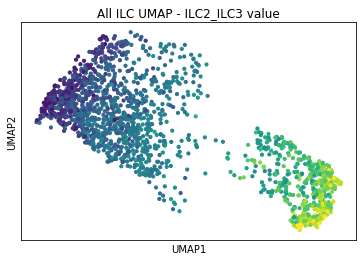

In [28]:
frame1 = plt.scatter(embedding[:,0], embedding[:,1], s= 10, c = ILC_val)
plt.title('All ILC UMAP - ILC2_ILC3 value')
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.show()

In [29]:
G = "Il4"
Gene_list = np.array(Gene_list)

for i in range(0,genes):
    if Gene_list[i] == G:
        gene_index = i

print(str(G)+' index: '+str(gene_index))

Il4 index: 2018


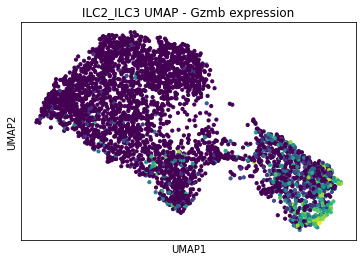

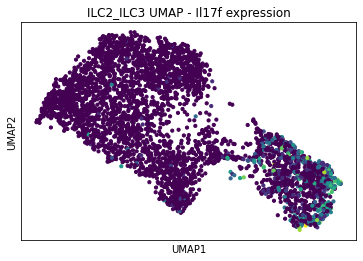

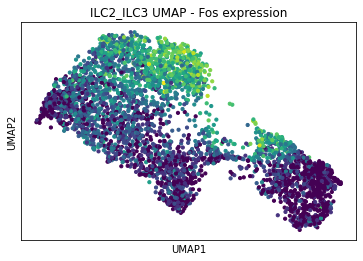

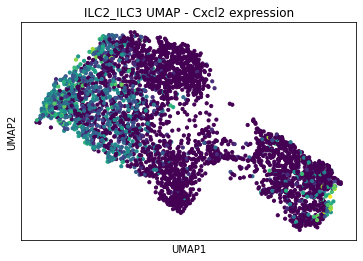

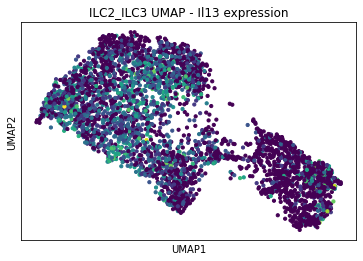

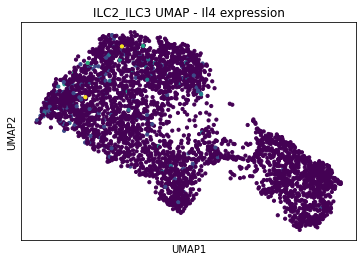

In [31]:
frame1 = plt.scatter(embedding[:,0], embedding[:,1], s= 10, c = ILC_gene_expression_values[:,1722])
plt.title('ILC2_ILC3 UMAP - Gzmb expression')
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.show()

frame1 = plt.scatter(embedding[:,0], embedding[:,1], s= 10, c = ILC_gene_expression_values[:,8])
plt.title('ILC2_ILC3 UMAP - Il17f expression')
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.show()

frame1 = plt.scatter(embedding[:,0], embedding[:,1], s= 10, c = ILC_gene_expression_values[:,2427])
plt.title('ILC2_ILC3 UMAP - Fos expression')
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.show()

frame1 = plt.scatter(embedding[:,0], embedding[:,1], s= 10, c = ILC_gene_expression_values[:,881])
plt.title('ILC2_ILC3 UMAP - Cxcl2 expression')
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.show()

frame1 = plt.scatter(embedding[:,0], embedding[:,1], s= 10, c = ILC_gene_expression_values[:,2019])
plt.title('ILC2_ILC3 UMAP - Il13 expression')
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.show()

frame1 = plt.scatter(embedding[:,0], embedding[:,1], s= 10, c = ILC_gene_expression_values[:,2018])
plt.title('ILC2_ILC3 UMAP - Il4 expression')
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.show()

## Preprocessing

In [11]:
print(ILC_val.shape)
ILC_val = np.array(ILC_val)

center = np.argsort(ILC_val)[ILC_val.shape[0]//2]
print(center)

(3807, 1)
[0]


In [12]:
from mSVD import eigen_plot, eigen_calc_from_dist_mat, eps_projection

ILCs = ILC_gene_expression_values
N, d = ILCs.shape

In [13]:
dist_mat = np.zeros((N, N))
for j in range(0,N):
    for k in range(0,N):
        if j != k:
            dist_mat[j, k] = np.linalg.norm(ILCs[j, :] - ILCs[k, :])


In [37]:
#print(dist_mat.shape)

#savetxt('dist_mat_allILC.csv', dist_mat, delimiter=',')

#dist_mat = pd.read_csv('dist_mat_allILC.csv', sep=",", header = None)

In [14]:
print(dist_mat.shape)

(3807, 3807)


Applying preproccessing to matrix - ILC_gene_expression_values

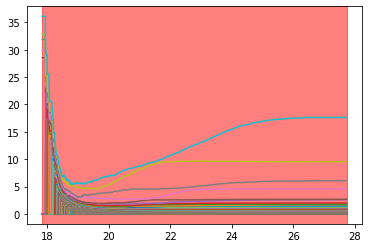

In [15]:
radii, eigval_list, _ = eigen_calc_from_dist_mat(ILCs, dist_mat, 1000)

rmin = radii[0]
rmax = radii[-1]

eigen_plot(eigval_list, radii, rmin, rmax)

In [24]:
(21.5 - rmin)/0.01

366.9243384145364

In [34]:
evec = _[367][:,0:2]
print(evec.shape)

(3000, 2)


In [35]:
proj = eps_projection(ILCs,evec,1000,2)

In [39]:
proj

[array([0., 0.]),
 array([-0.0004834 , -0.00057988]),
 array([0., 0.]),
 array([-0.00048316, -0.00057959]),
 array([0., 0.]),
 array([-0.00048307, -0.00057947]),
 array([0., 0.]),
 array([-0.00048325, -0.00057969]),
 array([0., 0.]),
 array([-0.00048322, -0.00057966]),
 array([0., 0.]),
 array([-0.0004834 , -0.00057988]),
 array([0., 0.]),
 array([-0.0004834 , -0.00057988]),
 array([0., 0.]),
 array([-0.00048311, -0.00057953]),
 array([0., 0.]),
 array([-0.00048311, -0.00057953]),
 array([0., 0.]),
 array([-0.00048322, -0.00057966]),
 array([0., 0.]),
 array([-0.00048325, -0.00057969]),
 array([0., 0.]),
 array([-0.00048322, -0.00057966]),
 array([0., 0.]),
 array([-0.00048322, -0.00057966]),
 array([0., 0.]),
 array([-0.0004834 , -0.00057988]),
 array([0., 0.]),
 array([-0.00048325, -0.00057969]),
 array([0., 0.]),
 array([-0.00048325, -0.00057969]),
 array([0., 0.]),
 array([-0.0004834 , -0.00057988]),
 array([0., 0.]),
 array([-0.0004834 , -0.00057988]),
 array([0., 0.]),
 array([-0

In [40]:
p = np.array(proj)

In [51]:
odd = np.zeros((1,2))
even = np.zeros((1,2))

for i in range(0,p.shape[0]):
    if i % 2 == 0:
        even = np.append(even, np.reshape(p[i,:], (1,2)), axis = 0)
    else:
        odd = np.append(odd, np.reshape(p[i,:], (1,2)), axis = 0)

even = even[1:, :]
odd = odd[1:, :]

In [58]:
print(odd.shape)
print(odd)
savetxt('eps_projection_allILC.csv', odd, delimiter=',')

(3807, 2)
[[-0.0004834  -0.00057988]
 [-0.00048316 -0.00057959]
 [-0.00048307 -0.00057947]
 ...
 [-0.0004834  -0.00057988]
 [-0.00048325 -0.00057969]
 [-0.0004834  -0.00057988]]


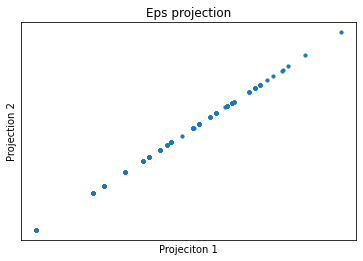

In [59]:
frame1 = plt.scatter(odd[:,0], odd[:,1], s= 10)
plt.title('Eps projection')
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('Projection 2')
plt.xlabel('Projeciton 1')
plt.show()